# Lecture 01: Introduction

Objectives:
1. Loading & manipulating datasets with Polars.
2. Introduction to NumPy.
3. KNN implementation by hand.

## Loading & manipulating datasets

We load data from external sources using the [Polars](https://docs.pola.rs/user-guide/getting-started/) library.

In [1]:
from pprint import pprint
import polars as pl

### Data: manually specified

- __Source__: Лебедев и Фадеева, гл. 15 № 38
- __Question__: is `after` greater than `before`?

In [2]:
df = pl.DataFrame({
    'before': [32, 25, 42, 35, 50, 40, 38, 19, 15],
    'after' : [35, 35, 25, 19, 40, 40, 75, 45, 18]
})
df

before,after
i64,i64
32,35
25,35
42,25
35,19
50,40
40,40
38,75
19,45
15,18


In [3]:
df['before']

before
i64
32
25
42
35
50
40
38
19
15


### Computations using columns

Polars lets us write expressions using columns of the dataframe. Actual computations are performed in "lightning-fast" Rust code.

In [4]:
df.select(
    # The two columns as-is
    'before',
    pl.col('after'),
    # New column called `diff`
    (pl.col('after') - pl.col('before')).alias('diff')
)

before,after,diff
i64,i64,i64
32,35,3
25,35,10
42,25,-17
35,19,-16
50,40,-10
40,40,0
38,75,37
19,45,26
15,18,3


In [5]:
df.select(
    # The two columns as-is
    'before',
    pl.col('after'),
    # New column called `diff`
    (pl.col('after') - pl.col('before')).alias('diff')
).select(
    # Compute mean and standard deviation
    pl.col('diff').mean().alias('diff_mean'),
    pl.col('diff').std().alias('diff_std'),
    # Number of observations
    pl.col('diff').count().alias('N'),
)

diff_mean,diff_std,N
f64,f64,u32
4.0,18.248288,9


__Intermediate result__: `mean(after - before) > 0`, so indeed, `after` seems greater than `before`.

However, further analysis is required: perhaps a hypothesis test?

1. Assume differences `after - before` are normally distributed: $$\Delta_n = x_n^a - x_n^b \sim \mathcal N(a, \sigma^2)$$
2. Hypotheses: $$\begin{aligned}H_0: &a=0\\ H_1: &a > 0\end{aligned}$$
3. Use 5% significance level.

Test statistic:
$$
\left. \frac{\bar \Delta - 0}{\hat s / \sqrt N} \right| H_0 \sim \mathrm{Student}(8)
$$

One-sided critical value: $t^* \approx 1.86$.

In [6]:
df1 = df.select(
    # The two columns as-is
    'before',
    pl.col('after'),
    # New column called `diff`
    (pl.col('after') - pl.col('before')).alias('diff')
).select(
    # Compute mean and standard deviation
    pl.col('diff').mean().alias('diff_mean'),
    pl.col('diff').std().alias('diff_std'),
    # Number of observations
    pl.col('diff').count().alias('N'),
).select(
    # New column is a computation
    abs(
        (pl.col('diff_mean') - 0) / (pl.col('diff_std') / pl.col('N').sqrt())
    ).alias('Test statistic'),
    # New column is a LITeral value
    pl.lit(1.86).alias('Critical value')
); df1

Test statistic,Critical value
f64,f64
0.657596,1.86


In [7]:
# Add new column, keep all existing ones
df1.with_columns(
    (
        abs(pl.col('Test statistic')) > pl.col('Critical value')
    ).alias('Reject H0?')
)

Test statistic,Critical value,Reject H0?
f64,f64,bool
0.657596,1.86,false


In [8]:
def run_test(diff: pl.col):
    # This is a regular Python function!
    mean = diff.mean()
    std = diff.std()
    N = diff.count()

    test_statistic = (mean - 0) / (std / N.sqrt()) # Just math!
    critical_value = 1.86

    reject_H0 = abs(test_statistic) > critical_value # Simple comparison
    return reject_H0

df.select(
    run_test(
        pl.col('after') - pl.col('before')
    ).alias('Reject H0?')
)

Reject H0?
bool
false


In [9]:
expr = run_test(
    pl.col('after') - pl.col('before')
).alias('Reject H0?')
print("Unevaluated expression:", expr)

df.select(expr) # Actually evaluate the expression

Unevaluated expression: [([([([(col("after")) - (col("before"))].mean()) - (dyn int: 0)]) / ([([(col("after")) - (col("before"))].std()) / ([(col("after")) - (col("before"))].count().sqrt())])].abs()) > (dyn float: 1.86)].alias("Reject H0?")


Reject H0?
bool
false


### Data loaded from CSV file

CSV file can be local or even online.

In [10]:
df_iris_dirty = pl.read_csv("https://github.com/Michael-tehc/MachineLearning-MSU/raw/refs/heads/main/data/IRIS.csv")
df_iris_dirty

sepal_length,sepal_width,petal_length,petal_width,species
f64,f64,f64,f64,str
5.1,3.5,1.4,0.2,"""Iris-setosa"""
4.9,3.0,1.4,0.2,"""Iris-setosa"""
4.7,3.2,1.3,0.2,"""Iris-setosa"""
4.6,3.1,1.5,0.2,"""Iris-setosa"""
5.0,3.6,1.4,0.2,"""Iris-setosa"""
…,…,…,…,…
6.7,3.0,5.2,2.3,"""Iris-virginica"""
6.3,2.5,5.0,1.9,"""Iris-virginica"""
6.5,3.0,5.2,2.0,"""Iris-virginica"""


`species` column is too verbose, remove prefix `Iris-`.

In [11]:
# 1. Split by `-`
df_iris_dirty.select(
    pl.col('species').str.split('-')
)

species
list[str]
"[""Iris"", ""setosa""]"
"[""Iris"", ""setosa""]"
"[""Iris"", ""setosa""]"
"[""Iris"", ""setosa""]"
"[""Iris"", ""setosa""]"
…
"[""Iris"", ""virginica""]"
"[""Iris"", ""virginica""]"
"[""Iris"", ""virginica""]"


In [12]:
# 2. Keep only second element of each list (at index 1)
df_iris_dirty.select(
    pl.col('species').str.split('-').list.get(1)
)

species
str
"""setosa"""
"""setosa"""
"""setosa"""
"""setosa"""
"""setosa"""
…
"""virginica"""
"""virginica"""
"""virginica"""


In [13]:
# 3. Put it all together
df_iris = pl.read_csv("https://github.com/Michael-tehc/MachineLearning-MSU/raw/refs/heads/main/data/IRIS.csv").select(
    pl.exclude('species'), # keep all columns EXCEPT `species`
    pl.col('species').str.split('-').list.get(1).alias('species')
); df_iris

sepal_length,sepal_width,petal_length,petal_width,species
f64,f64,f64,f64,str
5.1,3.5,1.4,0.2,"""setosa"""
4.9,3.0,1.4,0.2,"""setosa"""
4.7,3.2,1.3,0.2,"""setosa"""
4.6,3.1,1.5,0.2,"""setosa"""
5.0,3.6,1.4,0.2,"""setosa"""
…,…,…,…,…
6.7,3.0,5.2,2.3,"""virginica"""
6.3,2.5,5.0,1.9,"""virginica"""
6.5,3.0,5.2,2.0,"""virginica"""


Each row is a flower, each column is a characteristic of the flower.

- First 4 columns represent features: sepal length, sepal width, petal length and petal width.
  - Measurements of some parts of the flower.
- The last column is the correspondinc class.

In [14]:
# What kind of classes do we have?
sorted(df_iris['species'].unique())

['setosa', 'versicolor', 'virginica']

## NumPy: manipulating data

[NumPy](https://numpy.org) (name origin: "NUMerical PYthon") is "The fundamental package for scientific computing with Python".

1. NumPy arrays hold data: integers `0, -5`, floating-point numbers `0.0, -2.4, 3.141`, strings, ...
2. NumPy provides fast operations on arrays: linear algebra + indexing.

When to use Polars vs NumPy:
- Polars: load data and clean them up.
- NumPy: run computations on these data.

In [15]:
import numpy as np

In [16]:
# Vectors from lists
print(np.array([1,2,3,4,5]))
print(np.array([1,2,3,4, 5.0]))

[1 2 3 4 5]
[1. 2. 3. 4. 5.]


In [17]:
existing_list = [1,2,3,4,5]
np.array(existing_list) # Convert list to array

array([1, 2, 3, 4, 5])

In [18]:
# 2D arrays (matrices) from lists
np.array([
    [1,2,3],
    [4,5,6]
])

array([[1, 2, 3],
       [4, 5, 6]])

In [19]:
# Arrays with random elements
print('Random Normal(0,1) 2D array:')
print(np.random.randn(5,2))
print('\nRandom Uniform[-1, 1] 3D array:')
print(np.random.uniform(-1, 1, size=(3,4,5)))

Random Normal(0,1) 2D array:
[[-0.00892942  0.53816409]
 [ 0.10723916  2.01702534]
 [ 0.10327504  0.82369944]
 [ 1.30728455 -0.41162295]
 [-1.08121391  0.19572492]]

Random Uniform[-1, 1] 3D array:
[[[ 0.42303547  0.96802268  0.49998496  0.43447902  0.63845656]
  [ 0.5630228  -0.83793469  0.95471588 -0.67813523 -0.59886314]
  [-0.41235502  0.53071469 -0.75395024  0.64749837  0.50234572]
  [ 0.96732766 -0.8878616  -0.21191597  0.91699055  0.03345524]]

 [[ 0.44623969 -0.61197474 -0.13619604 -0.96906281  0.90582073]
  [ 0.38916652 -0.15933175 -0.86448334  0.62807526  0.67956777]
  [ 0.40129731  0.61977308  0.41397271 -0.90798567  0.19890546]
  [ 0.23119585  0.39193186 -0.88098605 -0.50087273  0.9133127 ]]

 [[ 0.44776547 -0.25344298 -0.05907441  0.52427244  0.18131288]
  [-0.51508892  0.56372987 -0.5129147  -0.63531778  0.55906563]
  [-0.09533819 -0.71690845  0.28769461  0.85464008  0.70370228]
  [-0.2088017  -0.41306823  0.83923031  0.72449936  0.58920366]]]


- We create arrays with `np.array`.
- The _type_ of an array is `np.ndarray`: "N-D array", "$N$-dimensional array".

In [20]:
type(np.array([1,2,3,4, 5.0]))

numpy.ndarray

In [21]:
# Useful properties
arr = np.array([1,2,3,4.0])
print(f"Shape               : {arr.shape=}")
print(f"Number of dimensions: {arr.ndim=}")
print(f"Type of elements    : {arr.dtype=}")

Shape               : arr.shape=(4,)
Number of dimensions: arr.ndim=1
Type of elements    : arr.dtype=dtype('float64')


### Indexing into NumPy arrays

In [22]:
# Same as regular Python indexing
arr = np.random.randn(5,2)
print(f"{arr.shape=}\n")
print("All rows, specific column    :", arr[:, 0])
print("All columns, specific row    :", arr[1, :])
print("Specific row, specific column:", arr[1, 0])

arr.shape=(5, 2)

All rows, specific column    : [-1.41123213  0.24845214 -0.87456949 -0.76806731  0.11593196]
All columns, specific row    : [ 0.24845214 -1.64337809]
Specific row, specific column: 0.24845213660157514


In [23]:
# Rows at indices [0, 2, 3], column 1 for each such row
arr[[0, 2, 3], 1]

array([1.06741452, 0.65275252, 0.59790931])

In [24]:
to_select = [True, True, False, False, True] # `False` == "don't select this row"
arr[to_select, :]

array([[-1.41123213,  1.06741452],
       [ 0.24845214, -1.64337809],
       [ 0.11593196,  0.82279518]])

### Doing math on NumPy arrays

In [25]:
print('NumPy arrays support math:')
print(
    "Add:",
    np.array([1,2,3]) + np.array([-1.5, 5.2, 0.0])
)
print(
    "Mul (elementwise):",
    np.array([1,2,3]) * np.array([-1.5, 5.2, 0.0])
)
print(
    "Cosine of mul:",
    np.cos(np.array([1,2,3]) * np.array([-1.5, 5.2, 0.0]))
)
print(
    "Vector norm of the above:",
    np.linalg.norm(
        np.cos(np.array([1,2,3]) * np.array([-1.5, 5.2, 0.0]))
    )
)
print("\nPython lists do NOT support math:")
print(
    [1,2,3] + [-1.5, 5.2, 0.0]
)
print('NOTE: this did NOT add values in the two arrays together!!\n')
try:
    [1,2,3] - [-1.5, 5.2, 0.0]
except Exception as e:
    print("Exception:", e)
try:
    [1,2,3] / [-1.5, 5.2, 0.0]
except Exception as e:
    print("Exception:", e)

print("Can sometimes apply NumPy functions to lists (NumPy auto-converts to arrays):")
print(f"{np.sin([1,2,3])=}")

NumPy arrays support math:
Add: [-0.5  7.2  3. ]
Mul (elementwise): [-1.5 10.4  0. ]
Cosine of mul: [ 0.0707372  -0.56098426  1.        ]
Vector norm of the above: 1.1487850489891294

Python lists do NOT support math:
[1, 2, 3, -1.5, 5.2, 0.0]
NOTE: this did NOT add values in the two arrays together!!

Exception: unsupported operand type(s) for -: 'list' and 'list'
Exception: unsupported operand type(s) for /: 'list' and 'list'
Can sometimes apply NumPy functions to lists (NumPy auto-converts to arrays):
np.sin([1,2,3])=array([0.84147098, 0.90929743, 0.14112001])


In [26]:
# Can apply elementwise functions to arbitrary high-dimensional arrays
np.sin(np.array([
    [1,2,3],
    [4,5,6]
]))

array([[ 0.84147098,  0.90929743,  0.14112001],
       [-0.7568025 , -0.95892427, -0.2794155 ]])

In [27]:
# Matrix multiplication
np.array([
    [1,2,3],
    [4,5,6]
]) @ np.array([7,8,9]) # shapes: (2, 3) x (3,) = (2, 3) x (3, 1) => (2,)

array([ 50, 122])

### Broadcasting

In [28]:
# Subtracting the same row from ALL rows in a matrix
mat = np.array([
    [1,2,3],
    [4,5,6]
])
vec = np.array([7,8,9])
print(f"{mat.shape=}, {vec.shape=}")
mat - vec

mat.shape=(2, 3), vec.shape=(3,)


array([[-6, -6, -6],
       [-3, -3, -3]])

Such subtraction doesn't make sense because dimensionalities differ:
- `mat: (2, 3)`, 2 dimensions
- `vec: (3,)`, 1 dimension

NumPy automatically duplicates `vec = [7,8,9]` into rows so that dimensions match:

$$
\begin{bmatrix}
1 & 2 & 3\\
4 & 5 & 6
\end{bmatrix} -
\begin{bmatrix}
7 & 8 & 9\\
7 & 8 & 9
\end{bmatrix} =
\begin{bmatrix}
1-7 & 2-7 & 3-7\\
4-7 & 5-7 & 6-7
\end{bmatrix} =
\begin{bmatrix}
-6 & -6 & -6\\
-3 & -3 & -3
\end{bmatrix}
$$

In [29]:
# Or manually add the missing 0th dimension
print(vec[None, :]) # [new dimension, all columns]
print(vec[:, None]) # [all rows, new dimension]
mat - vec[None, :]

[[7 8 9]]
[[7]
 [8]
 [9]]


array([[-6, -6, -6],
       [-3, -3, -3]])

In [30]:
mat_square = np.array([
    [1,2,3],
    [4,5,6],
    [7,8,9]
])
print("Subtracts from ROWS:")
print(mat_square - vec)
print("Force subtraction from ROWS:")
print(mat_square - vec[None, :])
print("\nForce subtraction from COLUMNS:")
print(mat_square - vec[:, None])

Subtracts from ROWS:
[[-6 -6 -6]
 [-3 -3 -3]
 [ 0  0  0]]
Force subtraction from ROWS:
[[-6 -6 -6]
 [-3 -3 -3]
 [ 0  0  0]]

Force subtraction from COLUMNS:
[[-6 -5 -4]
 [-4 -3 -2]
 [-2 -1  0]]


### Load Iris dataset into NumPy

- Polars: loading data & cleanup.
- NumPy: heavy-lifting.

In [31]:
iris_numpy = df_iris.to_numpy()
iris_numpy

array([[5.1, 3.5, 1.4, 0.2, 'setosa'],
       [4.9, 3.0, 1.4, 0.2, 'setosa'],
       [4.7, 3.2, 1.3, 0.2, 'setosa'],
       [4.6, 3.1, 1.5, 0.2, 'setosa'],
       [5.0, 3.6, 1.4, 0.2, 'setosa'],
       [5.4, 3.9, 1.7, 0.4, 'setosa'],
       [4.6, 3.4, 1.4, 0.3, 'setosa'],
       [5.0, 3.4, 1.5, 0.2, 'setosa'],
       [4.4, 2.9, 1.4, 0.2, 'setosa'],
       [4.9, 3.1, 1.5, 0.1, 'setosa'],
       [5.4, 3.7, 1.5, 0.2, 'setosa'],
       [4.8, 3.4, 1.6, 0.2, 'setosa'],
       [4.8, 3.0, 1.4, 0.1, 'setosa'],
       [4.3, 3.0, 1.1, 0.1, 'setosa'],
       [5.8, 4.0, 1.2, 0.2, 'setosa'],
       [5.7, 4.4, 1.5, 0.4, 'setosa'],
       [5.4, 3.9, 1.3, 0.4, 'setosa'],
       [5.1, 3.5, 1.4, 0.3, 'setosa'],
       [5.7, 3.8, 1.7, 0.3, 'setosa'],
       [5.1, 3.8, 1.5, 0.3, 'setosa'],
       [5.4, 3.4, 1.7, 0.2, 'setosa'],
       [5.1, 3.7, 1.5, 0.4, 'setosa'],
       [4.6, 3.6, 1.0, 0.2, 'setosa'],
       [5.1, 3.3, 1.7, 0.5, 'setosa'],
       [4.8, 3.4, 1.9, 0.2, 'setosa'],
       [5.0, 3.0, 1.6, 0.

In [32]:
iris_numpy.shape, df_iris.shape

((150, 5), (150, 5))

In [33]:
# Extract first 4 columns (4 features)
iris_numpy[:, 0:4].astype(float) # ALL rows, SPECIFIC columns

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1],
       [5.4, 3.7, 1.5, 0.2],
       [4.8, 3.4, 1.6, 0.2],
       [4.8, 3. , 1.4, 0.1],
       [4.3, 3. , 1.1, 0.1],
       [5.8, 4. , 1.2, 0.2],
       [5.7, 4.4, 1.5, 0.4],
       [5.4, 3.9, 1.3, 0.4],
       [5.1, 3.5, 1.4, 0.3],
       [5.7, 3.8, 1.7, 0.3],
       [5.1, 3.8, 1.5, 0.3],
       [5.4, 3.4, 1.7, 0.2],
       [5.1, 3.7, 1.5, 0.4],
       [4.6, 3.6, 1. , 0.2],
       [5.1, 3.3, 1.7, 0.5],
       [4.8, 3.4, 1.9, 0.2],
       [5. , 3. , 1.6, 0.2],
       [5. , 3.4, 1.6, 0.4],
       [5.2, 3.5, 1.5, 0.2],
       [5.2, 3.4, 1.4, 0.2],
       [4.7, 3.2, 1.6, 0.2],
       [4.8, 3.1, 1.6, 0.2],
       [5.4, 3.4, 1.5, 0.4],
       [5.2, 4.1, 1.5, 0.1],
       [5.5, 4.2, 1.4, 0.2],
       [4.9, 3

In [34]:
# First 4 columns are features, last column contains true labels
X = iris_numpy[:, 0:4].astype(float)
y = iris_numpy[:, -1]
X[0, :], y[0] # (x, y) for 0th iris

(array([5.1, 3.5, 1.4, 0.2]), 'setosa')

Each vector of features describing an object (iris) is called an __embedding__.

Feature vectors (embeddings) describe real-life objects in terms of numbers.

In [35]:
for n in [0,5,50,53,82,100,132]:
    print(f"Embedding of iris {n:>3d}:", X[n, :], "\tlabel:", y[n])

Embedding of iris   0: [5.1 3.5 1.4 0.2] 	label: setosa
Embedding of iris   5: [5.4 3.9 1.7 0.4] 	label: setosa
Embedding of iris  50: [7.  3.2 4.7 1.4] 	label: versicolor
Embedding of iris  53: [5.5 2.3 4.  1.3] 	label: versicolor
Embedding of iris  82: [5.8 2.7 3.9 1.2] 	label: versicolor
Embedding of iris 100: [6.3 3.3 6.  2.5] 	label: virginica
Embedding of iris 132: [6.4 2.8 5.6 2.2] 	label: virginica


In [36]:
# Average of each feature
X.mean(axis=0) # average over objects (rows, 0th dimension/axis)

array([5.84333333, 3.054     , 3.75866667, 1.19866667])

In [37]:
# Standard deviation of each feature
X.std(axis=0, ddof=1) # Use unbiased formula: `sum_of_squares/(N-1)`

array([0.82806613, 0.43359431, 1.76442042, 0.76316074])

## $K$ nearest neighbors classification

1. Have our dataset (150 irises, 4 features per flower).
2. __NOTE__: for us, this vector of 4 features _is_ the flower.
   - We know nothing more, the 4D vector (embedding) _represents_ the flower for our ML algorithms.
   - 4 features is way too low! Blame Fisher...
4. Given a new iris (one vector with 4 features describing the flower). Again, this vector is _everything_ we know about this flower, this is the only _representation_ of the iris we have.
5. What kind of iris is this?
   1. setosa?
   2. versicolor?
   3. virginica?
6. Well, what _known_ irises (our dataset) are similar to the new one? "Similar irises" == __neighbors__ of our new iris. If the majority of these neighbors are class `C`, then our iris must be class `C` as well.

In [38]:
def distance_between_irises(iris_A: np.ndarray, iris_B: np.ndarray) -> float:
    return np.linalg.norm(iris_A - iris_B)

In [39]:
pprint({
    'Distance from myself': distance_between_irises(X[0, :], X[0, :]),
    'Distance between iris 0 and iris 5': distance_between_irises(X[0, :], X[5, :]),
    'Distance between iris 3 and iris 4': distance_between_irises(X[3, :], X[4, :])
}, sort_dicts=False)

{'Distance from myself': np.float64(0.0),
 'Distance between iris 0 and iris 5': np.float64(0.6164414002968979),
 'Distance between iris 3 and iris 4': np.float64(0.6480740698407862)}


### What does it mean to be "$K$ nearest"?

1. Compute distances between new embedding $x^*$ and known embeddings $x_n$: $\{\lVert x^* - x_n \rVert \;| n \in 1,\dots,N\}$.
2. Sort distances from smallest to largest: $\lVert x^* - x_5 \rVert \leq \lVert x^* - x_3 \rVert \leq \dots$.
3. Record indices of $K$ embeddings with the smallest distances: $(5, 3, \dots)$.

Note: we need _small_ distances => _high_ "nearness" => "top-$K$ by similarity".

In [40]:
# Sorting
arr = np.array([-5, 2, -7, 3, 2, 0])
print(f"{arr=}")
print(f"{np.sort(arr)=}")
print(f"{np.argsort(arr)=}")

arr=array([-5,  2, -7,  3,  2,  0])
np.sort(arr)=array([-7, -5,  0,  2,  2,  3])
np.argsort(arr)=array([2, 0, 5, 1, 4, 3])


To sort the array in increasing order:

| Step | Action | Ordering |
| :--: | :----  | :------------ |
| 1 | Put `arr[2]` first | `arr[2]` |
| 2 | Put `arr[0]` second | `arr[2] <= arr[0]` |
| 3 | Put `arr[5]` third | `arr[2] <= arr[0] <= arr[5]` |
| 4 | Put `arr[1]` next | `arr[2] <= arr[0] <= arr[5] <= arr[1]` |
| 5 | Put `arr[4]` next | `arr[2] <= arr[0] <= arr[5] <= arr[1] <= arr[4]` |
| 6 | Put `arr[3]` last | `arr[2] <= arr[0] <= arr[5] <= arr[1] <= arr[4] <= arr[3]` |

In [41]:
print(f"np.sort(arr)      : {np.sort(arr)}")
print(f"arr[np.argsort...]: {arr[np.argsort(arr)]}")
arr[np.argsort(arr)] == np.sort(arr)

np.sort(arr)      : [-7 -5  0  2  2  3]
arr[np.argsort...]: [-7 -5  0  2  2  3]


array([ True,  True,  True,  True,  True,  True])

In [42]:
K = 3
print(f"The {K=} smallest elements are:", arr[np.argsort(arr)[:K]])

The K=3 smallest elements are: [-7 -5  0]


In [43]:
def K_neighbors(iris: np.ndarray, other_irises: np.ndarray, K: int, *, quiet=True) -> np.ndarray:
    "Return indices of `K` rows from `other_irises` closest to `iris`"
    F1, = iris.shape
    N, F2 = other_irises.shape
    assert F1 == F2 # numbers of features match
    F = F1

    # FIXME: this iterates over the whole dataset!
    # This is extremely inefficient, but easy to understand
    differences = other_irises - iris # auto broadcasts
    assert differences.shape == (N, F)
    
    distances = np.linalg.norm(
        differences,
        axis=1 # `[norm(x[i, :]) for i in range(x.shape[0])]`
    )
    assert distances.shape == (N, )
    if not quiet:
        print("Distances between query and every other iris:")
        with np.printoptions(formatter={'float_kind': '{:.2f}'.format}, suppress=True):
            print(distances)

    indices_with_smallest_distance = np.argsort(distances)[:K]
    if not quiet:
        with np.printoptions(formatter={'float_kind': '{:.2f}'.format}, suppress=True):
            print("Smallest distances:", distances[indices_with_smallest_distance])
    return indices_with_smallest_distance

In [44]:
K_neighbors(X[0, :], X, 4, quiet=False)

Distances between query and every other iris:
[0.00 0.54 0.51 0.65 0.14 0.62 0.52 0.17 0.92 0.47 0.37 0.37 0.59 0.99
 0.88 1.10 0.55 0.10 0.74 0.33 0.44 0.30 0.65 0.47 0.59 0.55 0.32 0.14
 0.14 0.54 0.54 0.39 0.62 0.81 0.47 0.37 0.41 0.47 0.87 0.14 0.17 1.35
 0.77 0.46 0.62 0.59 0.36 0.58 0.30 0.22 4.00 3.62 4.16 3.09 3.79 3.42
 3.79 2.35 3.75 2.89 2.70 3.23 3.15 3.70 2.58 3.63 3.44 3.01 3.77 2.88
 3.85 3.08 4.05 3.66 3.42 3.60 4.05 4.24 3.53 2.49 2.82 2.70 2.89 4.14
 3.41 3.52 3.91 3.62 3.00 3.02 3.31 3.60 3.01 2.39 3.15 3.07 3.13 3.35
 2.09 3.06 5.28 4.21 5.30 4.69 5.06 6.10 3.59 5.64 5.05 5.64 4.36 4.52
 4.85 4.19 4.42 4.63 4.65 6.24 6.50 4.14 5.12 4.03 6.21 4.11 4.97 5.31
 3.98 4.01 4.84 5.10 5.55 6.01 4.88 4.16 4.57 5.79 4.89 4.61 3.90 4.80
 5.02 4.64 4.21 5.26 5.14 4.65 4.28 4.46 4.65 4.14]
Smallest distances: [0.00 0.10 0.14 0.14]


array([ 0, 17,  4, 39])

### Finding the most common label among closest irises

Idea: if irises similar to me are `setosa`, then I'm probably `setosa` too!

In [45]:
from collections import Counter

In [46]:
Counter('abcdeabcdabcaba')

Counter({'a': 5, 'b': 4, 'c': 3, 'd': 2, 'e': 1})

In [47]:
cnt = Counter()
cnt['setosa'] += 1
cnt['virginica'] += 1
cnt['setosa'] += 1
cnt

Counter({'setosa': 2, 'virginica': 1})

In [48]:
Counter('abcdeabcdabcaba').most_common()

[('a', 5), ('b', 4), ('c', 3), ('d', 2), ('e', 1)]

In [49]:
Counter('abcdeabcdabcaba').most_common(1)

[('a', 5)]

### Final classifier

In [50]:
def KNN_predict(new_iris: np.ndarray, X: np.ndarray, y: np.ndarray, K: int, *, quiet=True):
    new_iris = np.array(new_iris)
    assert X.shape == (y.shape[0], new_iris.shape[0])
    assert K > 0

    # 1. Find nearest neighbors
    indices_with_smallest_distance = K_neighbors(new_iris, X, K, quiet=quiet)
    # 2. Their labels
    labels_of_closest_objects = y[indices_with_smallest_distance]
    if not quiet:
        print("Labels of most similar irises:",labels_of_closest_objects)

    # 3. Find most common label
    cnt = Counter(labels_of_closest_objects)
    if not quiet:
        print("Distribution of labels:", cnt)
    
    (most_common_label, objects_with_this_label), = cnt.most_common(1)
    if not quiet:
        print(f"Most common label      : {most_common_label}")
        print(f"Objects with this label: {objects_with_this_label} ({objects_with_this_label/K:.2%} of top-{K})")
    # 4. This most common label is our prediction!
    return most_common_label

In [51]:
KNN_predict(X[0, :], X, y, 5)

'setosa'

Wait, where's `KNN_train`?

`KNN` doesn't "train" (estimate) any parameters, so there's nothing to train.

In [52]:
KNN_predict(X[0, :], X, y, 5, quiet=False)

Distances between query and every other iris:
[0.00 0.54 0.51 0.65 0.14 0.62 0.52 0.17 0.92 0.47 0.37 0.37 0.59 0.99
 0.88 1.10 0.55 0.10 0.74 0.33 0.44 0.30 0.65 0.47 0.59 0.55 0.32 0.14
 0.14 0.54 0.54 0.39 0.62 0.81 0.47 0.37 0.41 0.47 0.87 0.14 0.17 1.35
 0.77 0.46 0.62 0.59 0.36 0.58 0.30 0.22 4.00 3.62 4.16 3.09 3.79 3.42
 3.79 2.35 3.75 2.89 2.70 3.23 3.15 3.70 2.58 3.63 3.44 3.01 3.77 2.88
 3.85 3.08 4.05 3.66 3.42 3.60 4.05 4.24 3.53 2.49 2.82 2.70 2.89 4.14
 3.41 3.52 3.91 3.62 3.00 3.02 3.31 3.60 3.01 2.39 3.15 3.07 3.13 3.35
 2.09 3.06 5.28 4.21 5.30 4.69 5.06 6.10 3.59 5.64 5.05 5.64 4.36 4.52
 4.85 4.19 4.42 4.63 4.65 6.24 6.50 4.14 5.12 4.03 6.21 4.11 4.97 5.31
 3.98 4.01 4.84 5.10 5.55 6.01 4.88 4.16 4.57 5.79 4.89 4.61 3.90 4.80
 5.02 4.64 4.21 5.26 5.14 4.65 4.28 4.46 4.65 4.14]
Smallest distances: [0.00 0.10 0.14 0.14 0.14]
Labels of most similar irises: ['setosa' 'setosa' 'setosa' 'setosa' 'setosa']
Distribution of labels: Counter({'setosa': 5})
Most common label   

'setosa'

In [53]:
pprint({
    'true': y[0],
    'prediction(K=1)': KNN_predict(X[0, :], X, y, 1),
    'prediction(K=5)': KNN_predict(X[0, :], X, y, 5),
    'prediction(K=10)': KNN_predict(X[0, :], X, y, 10),
})

{'prediction(K=1)': 'setosa',
 'prediction(K=10)': 'setosa',
 'prediction(K=5)': 'setosa',
 'true': 'setosa'}


### Main point of machine learning

1. Model is trained on finite data, but still works on _new_, unseen data!
2. The output for new data should be correct (_generalization_).

In [54]:
X[0, :], y[0]

(array([5.1, 3.5, 1.4, 0.2]), 'setosa')

In [55]:
# New, unseen iris
x_new = [5, 3, 1, 0.1]
KNN_predict(
    x_new,
    X, y, 5
)

'setosa'

In [56]:
X[-1, :], y[-1]

(array([5.9, 3. , 5.1, 1.8]), 'virginica')

In [57]:
KNN_predict(
    [6, 3, 5, 2],
    X, y, 5
)

'virginica'

### Our classifier is sometimes confused

In [58]:
for K in [1, 2, 3, 4, 5, 10, 20]:
    y_pred = KNN_predict(
        [3, 3, 5, 2],
        X, y, K
    )
    print(f"{K=:<2d} {y_pred=}")

K=1  y_pred='virginica'
K=2  y_pred='virginica'
K=3  y_pred='versicolor'
K=4  y_pred='virginica'
K=5  y_pred='versicolor'
K=10 y_pred='virginica'
K=20 y_pred='versicolor'


In [59]:
KNN_predict(
    [3, 3, 5, 2],
    X, y, 20, quiet=False
)

Distances between query and every other iris:
[4.57 4.45 4.46 4.25 4.53 4.47 4.31 4.43 4.26 4.41 4.66 4.27 4.45 4.53
 5.15 4.91 4.78 4.53 4.66 4.49 4.48 4.44 4.71 4.20 4.03 4.34 4.28 4.54
 4.60 4.21 4.25 4.55 4.68 4.89 4.41 4.66 4.84 4.41 4.35 4.48 4.56 4.40
 4.35 4.22 4.15 4.37 4.46 4.34 4.61 4.50 4.06 3.48 3.93 2.87 3.56 2.84
 3.35 2.80 3.69 2.55 2.87 3.05 3.41 3.17 3.04 3.80 2.69 3.12 3.37 3.00
 2.92 3.34 3.38 3.22 3.54 3.70 3.86 3.71 3.08 3.27 2.98 3.05 3.13 3.04
 2.50 3.09 3.75 3.50 2.84 2.83 2.72 3.18 3.10 2.89 2.82 2.93 2.90 3.35
 3.08 2.94 3.50 2.82 4.20 3.36 3.60 4.87 2.05 4.50 3.82 4.41 3.51 3.43
 3.83 2.75 2.84 3.43 3.54 5.07 5.09 3.14 3.98 2.61 5.00 3.32 3.78 4.33
 3.22 3.11 3.46 4.29 4.54 5.16 3.46 3.35 3.24 4.84 3.40 3.44 3.01 3.92
 3.77 3.91 2.82 3.92 3.81 3.72 3.34 3.51 3.26 2.91]
Smallest distances: [2.05 2.50 2.55 2.61 2.69 2.72 2.75 2.80 2.82 2.82 2.82 2.83 2.84 2.84
 2.84 2.87 2.87 2.89 2.90 2.91]
Labels of most similar irises: ['virginica' 'versicolor' 'versicolor'

'versicolor'

Reason for confusion: `versicolor` and `virginica` are _both_ pretty close to the point `[3, 3, 5, 2]`!

This is fine:

> [All models are wrong](https://en.wikipedia.org/wiki/All_models_are_wrong), but some are useful.

### We have KNN at home!

In [60]:
class KNN:
    def __init__(self, K: int):
        assert K > 0
        self.K = K

    def fit(self, X: np.ndarray, y: np.ndarray):
        X, y = np.array(X), np.array(y)
        assert X.ndim == 2
        assert y.shape == (X.shape[0], )
        self.X_, self.y_ = X, y
        return self

    def predict_one(self, x_new: np.ndarray):
        x_new = np.array(x_new)
        assert x_new.shape == (self.X_.shape[1], )
        return KNN_predict(x_new, self.X_, self.y_, self.K)

    def predict(self, X_new: np.ndarray):
        X_new = np.array(X_new)
        if X_new.ndim == 1:
            X_new = X_new[None, :]
        assert X_new.ndim == 2
        return np.array([
            self.predict_one(X_new[n, :])
            for n in range(X_new.shape[0])
        ])

In [61]:
KNN(5).fit(X, y).predict(
    [3, 3, 5, 2]
)

array(['versicolor'], dtype='<U10')

In [62]:
KNN(5).fit(X, y).predict(X)

array(['setosa', 'setosa', 'setosa', 'setosa', 'setosa', 'setosa',
       'setosa', 'setosa', 'setosa', 'setosa', 'setosa', 'setosa',
       'setosa', 'setosa', 'setosa', 'setosa', 'setosa', 'setosa',
       'setosa', 'setosa', 'setosa', 'setosa', 'setosa', 'setosa',
       'setosa', 'setosa', 'setosa', 'setosa', 'setosa', 'setosa',
       'setosa', 'setosa', 'setosa', 'setosa', 'setosa', 'setosa',
       'setosa', 'setosa', 'setosa', 'setosa', 'setosa', 'setosa',
       'setosa', 'setosa', 'setosa', 'setosa', 'setosa', 'setosa',
       'setosa', 'setosa', 'versicolor', 'versicolor', 'versicolor',
       'versicolor', 'versicolor', 'versicolor', 'versicolor',
       'versicolor', 'versicolor', 'versicolor', 'versicolor',
       'versicolor', 'versicolor', 'versicolor', 'versicolor',
       'versicolor', 'versicolor', 'versicolor', 'versicolor',
       'versicolor', 'virginica', 'versicolor', 'virginica', 'versicolor',
       'versicolor', 'versicolor', 'versicolor', 'versicolor',
     

### How wrong are we?

$$
\mathrm{accuracy}(y, \hat y) = \frac1N \sum_{n=1}^N 1(y_n = \hat y_n)
$$

In [63]:
(KNN(5).fit(X, y).predict(X) == y).mean()

np.float64(0.9666666666666667)

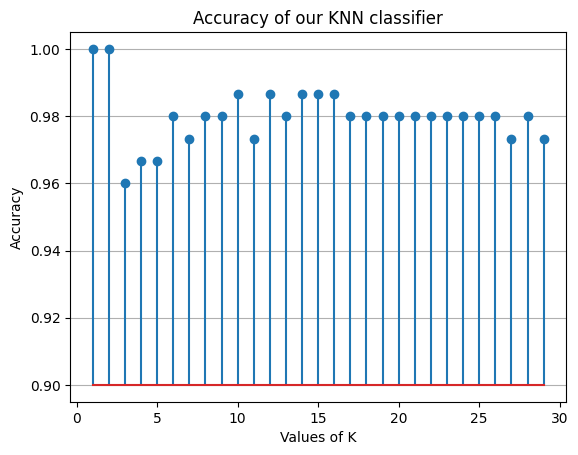

In [64]:
import matplotlib.pyplot as plt, matplotlib as mpl

K_values = np.arange(1, 30)
accuracies = np.array([
    (KNN(K).fit(X, y).predict(X) == y).mean()
    for K in K_values
])
plt.stem(K_values, accuracies, bottom=0.9)
plt.grid(True, which='both', axis='y')
plt.title('Accuracy of our KNN classifier')
plt.ylabel('Accuracy'); plt.xlabel('Values of K');

__NOTE:__ we measured accuracy for the same dataset we used to train/fit the model!

These results may __NOT__ be indicative of "real-world" performance on new data!
- E.g.: of course $K=1$ will learn the true labels perfectly! But will it generalize?

## KNN in the wild: scikit-learn

Documentation: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

In [65]:
from sklearn.neighbors import KNeighborsClassifier

In [66]:
knn_sklearn = KNeighborsClassifier(5, algorithm='brute').fit(X, y)
knn_sklearn

,"n_neighbors n_neighbors: int, default=5Number of neighbors to use by default for :meth:`kneighbors` queries.",5
,"weights weights: {'uniform', 'distance'}, callable or None, default='uniform'Weight function used in prediction. Possible values:- 'uniform' : uniform weights. All points in each neighborhood are weighted equally.- 'distance' : weight points by the inverse of their distance. in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.- [callable] : a user-defined function which accepts an array of distances, and returns an array of the same shape containing the weights.Refer to the example entitled:ref:`sphx_glr_auto_examples_neighbors_plot_classification.py`showing the impact of the `weights` parameter on the decisionboundary.",'uniform'
,"algorithm algorithm: {'auto', 'ball_tree', 'kd_tree', 'brute'}, default='auto'Algorithm used to compute the nearest neighbors:- 'ball_tree' will use :class:`BallTree`- 'kd_tree' will use :class:`KDTree`- 'brute' will use a brute-force search.- 'auto' will attempt to decide the most appropriate algorithm based on the values passed to :meth:`fit` method.Note: fitting on sparse input will override the setting ofthis parameter, using brute force.",'brute'
,"leaf_size leaf_size: int, default=30Leaf size passed to BallTree or KDTree. This can affect thespeed of the construction and query, as well as the memoryrequired to store the tree. The optimal value depends on thenature of the problem.",30
,"p p: float, default=2Power parameter for the Minkowski metric. When p = 1, this is equivalentto using manhattan_distance (l1), and euclidean_distance (l2) for p = 2.For arbitrary p, minkowski_distance (l_p) is used. This parameter is expectedto be positive.",2
,"metric metric: str or callable, default='minkowski'Metric to use for distance computation. Default is ""minkowski"", whichresults in the standard Euclidean distance when p = 2. See thedocumentation of `scipy.spatial.distance`_ andthe metrics listed in:class:`~sklearn.metrics.pairwise.distance_metrics` for valid metricvalues.If metric is ""precomputed"", X is assumed to be a distance matrix andmust be square during fit. X may be a :term:`sparse graph`, in whichcase only ""nonzero"" elements may be considered neighbors.If metric is a callable function, it takes two arrays representing 1Dvectors as inputs and must return one value indicating the distancebetween those vectors. This works for Scipy's metrics, but is lessefficient than passing the metric name as a string.",'minkowski'
,"metric_params metric_params: dict, default=NoneAdditional keyword arguments for the metric function.",None
,"n_jobs n_jobs: int, default=NoneThe number of parallel jobs to run for neighbors search.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.Doesn't affect :meth:`fit` method.",None


In [67]:
indices = [0,5,50,53,82,100,132]
print('Truth     :', y[indices])
print('Prediction:', knn_sklearn.predict(X[indices, :]))

Truth     : ['setosa' 'setosa' 'versicolor' 'versicolor' 'versicolor' 'virginica'
 'virginica']
Prediction: ['setosa' 'setosa' 'versicolor' 'versicolor' 'versicolor' 'virginica'
 'virginica']


### What we learned: a decision function

Our fitted KNN is a function $$f: \mathbb R^4 \to \{\mathrm{setosa}, \mathrm{versicolor}, \mathrm{virginica}\}$$

In [68]:
def plot_decision_function(K: int, X: np.ndarray, y: np.ndarray, px: int, py: int):
    knn = KNeighborsClassifier(K, algorithm='brute').fit(X, y)

    X_noised = np.vstack([
        X + np.random.uniform(-2, 2, size=X.shape)
        for _ in range(100)
    ] + [
        X + np.random.uniform(-1, 1, size=X.shape)
        for _ in range(100)
    ] + [
        X + np.random.uniform(-0.5, 0.5, size=X.shape)
        for _ in range(100)
    ] + [X])
    y_pred = knn.predict(X_noised)
    categories = {cls: i for i, cls in enumerate(sorted(np.unique(y_pred)))}
    cat_to_names = {i: cls for cls, i in categories.items()}
    y_pred_coded = np.array([categories[cls] for cls in y_pred])

    levels = range(len(categories)+1)

    fig, ax = plt.subplots()
    ax.set_title('Decision function')
    ax.set_xlabel(f'x{px}')
    ax.set_ylabel(f'x{py}')
    tcf = ax.tricontourf(X_noised[:, px], X_noised[:, py], y_pred_coded, levels=levels, cmap='Accent')
    cb = fig.colorbar(tcf, ax=ax, ticks=levels)
    midpoints = [(levels[i] + levels[i+1]) / 2 for i in range(len(levels) - 1)]
    cb.set_ticks(midpoints)
    cb.set_ticklabels([cat_to_names[cat] for cat in range(len(levels) - 1)])
    
    ax.grid()
    fig.tight_layout()
    return fig

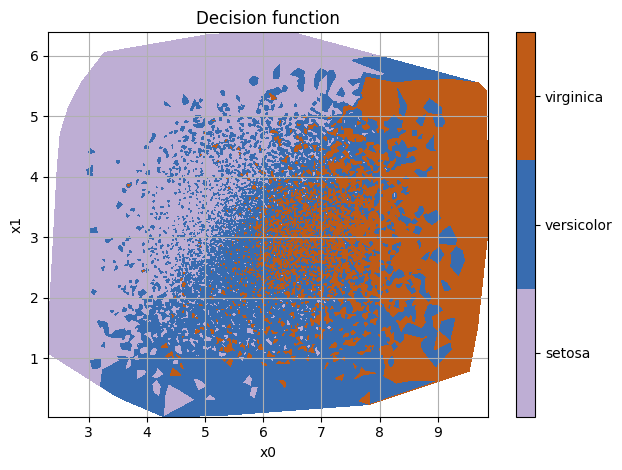

In [69]:
plot_decision_function(5, X, y, 0, 1);

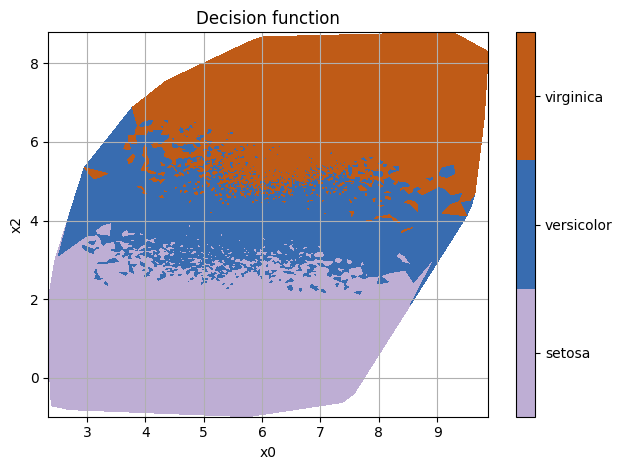

In [70]:
plot_decision_function(5, X, y, 0, 2);

This is the __pattern__ we learned!